## 2.18 [Homework](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/02-regression/homework.md)

In [1]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

In [2]:
import pandas as pd

df = (
    pd.read_csv("laptops.csv")
    .rename(columns=lambda x: x.lower().replace(' ', '_'))
    [[
        "ram",
        "storage",
        "screen",
        "final_price"
    ]]
)
df

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01
...,...,...,...,...
2155,16,1000,17.3,2699.99
2156,16,1000,17.3,2899.99
2157,32,1000,17.3,3399.99
2158,16,1000,13.4,1899.99


## EDA

Look at the `final_price` variable. Does it have a long tail?

<Axes: xlabel='final_price', ylabel='Count'>

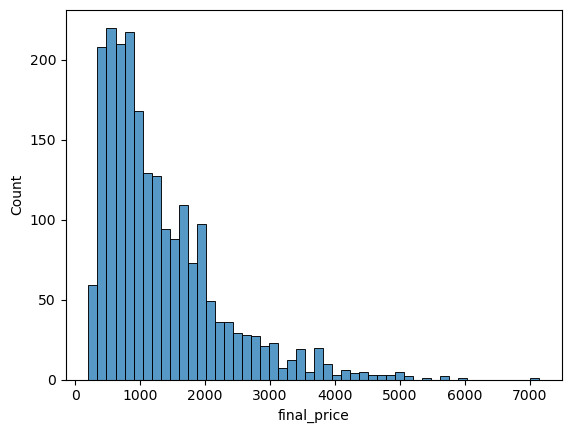

In [70]:
import seaborn as sns

sns.histplot(df.final_price, bins=50)

`final_price` indeed does have a long tail, so a log transformation might need to be applied to it.

<Axes: xlabel='final_price', ylabel='Count'>

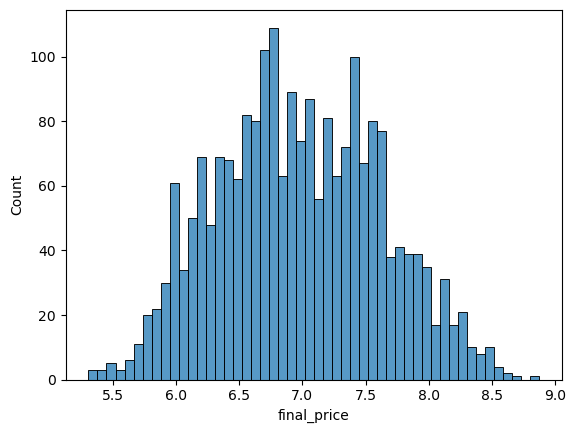

In [71]:
import numpy as np

sns.histplot(np.log1p(df.final_price), bins=50)

## Q1

In [72]:
f"The column with missing values is: {df.columns[df.isna().sum(axis=0) > 0][0]}"

'The column with missing values is: screen'

## Q2

In [73]:
f"The median for 'ram' is: {df['ram'].median():.0f}"

"The median for 'ram' is: 16"

## Prepare and Split the Dataset

In [81]:
def prep_X_y(df, fillna_method, seed=42):
    """
    fillna_method can either be "mean" or 0
    """
    n = len(df)
    n_val = n_test =  int(0.2 * n)
    n_train = n - n_val - n_test

    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    df = (
        df
        .assign(
            screen=df["screen"].fillna(df.loc[idx[:n_train], "screen"].mean() if fillna_method=="mean" else 0)
        )
        .assign(
            # ram=lambda df_: np.log1p(df_.ram),
            # storage=lambda df_: np.log1p(df_.storage),
            # screen=lambda df_: np.log1p(df_.screen),
            # final_price=lambda df_: np.log1p(df_.final_price),
        )
    )

    X = df.drop(columns="final_price").values
    X = np.column_stack([np.ones(X.shape[0]), X])

    y = df["final_price"].values

    X_train = X[idx[:n_train]]
    X_val = X[idx[n_train:n_train+n_val]]
    X_test = X[idx[n_train+n_val:]]
    
    y_train = y[idx[:n_train]]
    y_val = y[idx[n_train:n_train+n_val]]
    y_test = y[idx[n_train+n_val:]]

    return (X_train, X_val, X_test, y_train, y_val, y_test)

## Q3

In [82]:
def train_linear_regression(X, y, r=0):
    """By default no regularization is applied. 
    Set r to nonzero value for regularization."""
    return np.linalg.inv(X.T @ X + r * np.eye(X.shape[1])) @ X.T @ y

def rmse(y, y_hat):
    return np.sqrt(((y_hat - y) ** 2).mean())

In [84]:
# fillna with 0
X_train, X_val, X_test, y_train, y_val, y_test = prep_X_y(df, fillna_method=0)
w = train_linear_regression(X_train, y_train)
y_hat_val = X_val @ w
# print(f"RMSE for option to fill with 0 is: {round(rmse(np.expm1(y_val), np.expm1(y_hat_val)), 2)}")
print(f"RMSE for option to fill with 0 is: {round(rmse(y_val, y_hat_val), 2)}")

# fillna with mean
X_train, X_val, X_test, y_train, y_val, y_test = prep_X_y(df, "mean")
w = train_linear_regression(X_train, y_train)
y_hat_val = X_val @ w
# print(f"RMSE for option to fill with mean is: {round(rmse(np.expm1(y_val), np.expm1(y_hat_val)), 2)}")
print(f"RMSE for option to fill with mean is: {round(rmse(y_val, y_hat_val), 2)}")


RMSE for option to fill with 0 is: 597.36
RMSE for option to fill with mean is: 600.27


## Q4

In [86]:
r_list = [0, 0.01, 0.1, 1, 5, 10, 100]
rmse_list = []

for r in r_list:
    X_train, X_val, X_test, y_train, y_val, y_test = prep_X_y(df, fillna_method=0)
    w = train_linear_regression(X_train, y_train, r)
    y_hat_val = X_val @ w
    # rmse_list.append(round(rmse(np.expm1(y_val), np.expm1(y_hat_val)), 2))
    rmse_list.append(round(rmse(y_val, y_hat_val), 2))
    print(f"RMSE for r={r}: {rmse_list[-1]:.2f}")

RMSE for r=0: 597.36
RMSE for r=0.01: 597.36
RMSE for r=0.1: 597.35
RMSE for r=1: 597.21
RMSE for r=5: 597.01
RMSE for r=10: 597.06
RMSE for r=100: 597.90


## Q5

In [67]:
seed_list = range(10)
rmse_list = []

for seed in seed_list:
    X_train, X_val, X_test, y_train, y_val, y_test = prep_X_y(df, fillna_method=0, seed=seed)
    w = train_linear_regression(X_train, y_train)
    y_hat_val = X_val @ w
    # rmse_list.append(round(rmse(np.expm1(y_val), np.expm1(y_hat_val)), 2))
    rmse_list.append(round(rmse(y_val, y_hat_val), 2))

print(f"The standard deviation of all the scores is: {np.std(rmse_list):.3f}")

The standard deviation of all the scores is: 30.149


## Q6

In [68]:
X_train, X_val, X_test, y_train, y_val, y_test = prep_X_y(df, fillna_method=0, seed=9)
X_train_val = np.vstack([X_train, X_val])
y_train_val = np.hstack([y_train, y_val])
w = train_linear_regression(X_train_val, y_train_val, r=0.001)
y_hat_test = X_test @ w
# print(round(rmse(np.expm1(y_test), np.expm1(y_hat_test)), 2))
print(round(rmse(y_test, y_hat_test), 2))

606.16
